# Итоговый проект "Классификация акций для бенчмаркинга нефтегазовых компаний"

## Импорт данных

In [14]:
import random
import re
import string
from collections import Counter
from typing import List
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

from tqdm.auto import tqdm
from razdel import tokenize
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup

import seaborn
from transformers import BertTokenizer, BertModel

seaborn.set(palette='summer')
PRE_TRAINED_MODEL_NAME = 'DeepPavlov/rubert-base-cased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
device

device(type='cuda')

## Предобработка данных

In [2]:
df = pd.read_csv('data/competitors_promo.csv', sep=';')
df[df.promo_type.isna()]

,promo_name,promo_description,promo_type
143,Получи до 100 000₽ при покупке квартиры!,Теперь при покупке квартиры в любом из наших ж...,NaN


In [3]:
df.promo_type.fillna('stiu', inplace=True)

In [4]:
label2id = {'np': 1, 'stiu': 0}
id2label = {1: 'np', 0: 'stiu'}

Объединим заголовок акции и ее содержание

In [5]:
df['text'] = df['promo_name'] + ' ' + df['promo_description']
df['label'] = df['promo_type'].apply(lambda x: label2id[x])

In [6]:
X = df[['text']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Функция для текстового препроцессинга: убирает пунктуацию, ссылки, erid и инн данные и токенизирует слова с начальной форме

In [7]:
nlp = spacy.load('ru_core_news_lg')

def text_preprocessing(example):
    processed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))
    processed_text = re.sub("https*\S+", " ", processed_text)
    processed_text = re.sub("erid: [A-Za-z]+", " ", processed_text)
    processed_text = re.sub("инн \d+", " ", processed_text)
    processed_text = re.sub("\s+", " ", processed_text)
    processed_text = processed_text.replace('"', '')
    spacy_results = nlp(processed_text)
    processed_text = ' '.join([token.lemma_ for token in spacy_results])
    return processed_text

In [8]:
words = Counter()

for example in tqdm(X_train['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    processed_text = text_preprocessing(example)

    for word in tokenize(processed_text):
        words[word.text] += 1

# специальные токены для обозначения неизвестного слова, начала строки, конца строки и пад токена
vocab = {'<unk>', '<bos>', '<eos>', '<pad>'}

# слова которые встречаются реже `counter_threshold` не рассматриваются и помечаются как <unk>
counter_threshold = 3

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}


  0%|          | 0/421 [00:00<?, ?it/s]

Размер словаря: 1109


Класс WordDataset, инкапсулирующий предобработку и трансформацию в токены, реализующая интерфейс для работы с объектом-итератором DataLoader

In [9]:
class WordDataset:
    unk_id = word2ind['<unk>']
    bos_id = word2ind['<bos>']
    eos_id = word2ind['<eos>']
    pad_id = word2ind['<pad>']

    def __init__(self, sentences, labels):
        self.data = sentences.to_numpy()
        self.labels = labels.to_numpy()


    def __getitem__(self, idx: int) -> List[int]:

        tokenized_sentence = self.convert_to_inds(self.data[idx])

        train_sample = {
            "text": tokenized_sentence,
            "label": self.labels[idx]
        }

        return train_sample

    @classmethod
    def convert_to_inds(cls, text):
        processed_text = text_preprocessing(text)

        tokenized_sentence = [cls.bos_id]
        for word in tokenize(processed_text):
            word_text = word.text
            if word_text.isdigit():
                result_token = cls.unk_id
            else:
                result_token = word2ind.get(word_text, cls.unk_id)
            tokenized_sentence.append(result_token)

        tokenized_sentence.append(cls.eos_id)
        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)


# функции добавляющие пад-токен в батч-данных
def padding_batch(input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.LongTensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)
    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    return sequences


def collate_fn_with_padding(
        input_batch: List[List[int]],
        pad_id=word2ind['<pad>'],
        max_len=256
) -> tuple[torch.Tensor, torch.Tensor]:
    sequences = padding_batch(input_batch, pad_id, max_len)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    return sequences, labels

In [10]:
train_dataset = WordDataset(X_train['text'], y_train)

eval_dataset = WordDataset(X_test['text'], y_test)

batch_size = 8
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и тестирование RNN-моделей

Будем пробовать различные модели с RNN-архитектурой

In [16]:
# универсальная функция для обучения RNN-моделей
def train(model, criterion, optimizer, scheduler, train_dataloader, val_dataloader=None, epochs=3, evaluation=False):

    print("Start training...\n")
    losses = []
    acc = []
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()
        total_loss, batch_loss, batch_counts = 0, 0, 0
        epoch_losses = []
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts += 1
            *b_inputs, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()
            logits = model(*b_inputs)
            loss = criterion(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            epoch_losses.append(loss.item())
            if (step != 0 and step % 10 == 0) or step == len(train_dataloader) - 1:
                time_elapsed = time.time() - t0_batch
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation:
            model.eval()
            val_loss, val_accuracy = evaluate(model, val_dataloader, criterion)
            acc.append(val_accuracy)
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy*100:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
            model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))
        print("\n")

    print("Training complete!")
    return losses, acc


def evaluate(model, val_dataloader, criterion):

    val_loss = []

    predictions = []
    target = []
    with torch.no_grad():
        for batch in val_dataloader:
            *b_inputs, b_labels = tuple(t.to(device) for t in batch)
            logits = model(*b_inputs)
            loss = criterion(logits, b_labels)
            val_loss.append(loss.item())
            predictions.append(logits.argmax(dim=1))
            target.append(b_labels)

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()
    val_loss = np.mean(val_loss)

    return val_loss, accuracy

In [21]:
def predict(model, predict_data: List[str]) -> float:
    """
    Predict label
    """

    batch_data = [{'text': WordDataset.convert_to_inds(t)} for t in predict_data]
    batch_data = padding_batch(batch_data)

    with torch.no_grad():
        logits = model(batch_data)
        ids = logits.argmax(dim=1)
    predictions = [id2label[i] for i in ids.tolist()]
    result = pd.DataFrame(zip(predict_data, predictions), columns=['text', 'prediction'])
    return result

Baseline RNN-модели: образуем ембеддинги слов, пропускаем вектора слов через RNN и получаем логиты стандартными слоями типа Tanh и Linear. Одна особенность: для того, чтобы классифицировать текст, необходимо ембеддинги слов каким-нибудь образом сгруппировать. Наиболее простая логика либо взять максимальные значения либо сумму (тогда можем получить неадекватные вектора, исключаем), среднее. Эти два типа агрегации протестируем для наших моделей

### Simple RNN model

In [17]:
class RNNCharLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, aggregation_type: str = 'max'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, 2)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

#### Max embeddings aggregation

In [ ]:
epochs = 5
rnn_model_max_emb = RNNCharLM(256, len(vocab), aggregation_type='max')
rnn_model_max_emb.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(rnn_model_max_emb.parameters())
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, # Default value
                                            num_training_steps=total_steps)
rnn_losses_max_emb, rnn_accuracy_max_emb = train(
    rnn_model_max_emb,
    criterion,
    optimizer,
    scheduler,
    train_dataloader,
    eval_dataloader,
    epochs=epochs,
    evaluation=True
)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   10    |   1.033466   |     -      |     -     |   3.39   
   1    |   20    |   0.801694   |     -      |     -     |   2.74   
   1    |   30    |   0.593924   |     -      |     -     |   3.45   
   1    |   40    |   0.406812   |     -      |     -     |   3.27   
   1    |   50    |   0.435866   |     -      |     -     |   2.55   
   1    |   52    |   0.194841   |     -      |     -     |   0.46   
----------------------------------------------------------------------
   1    |    -    |   0.644165   |  0.388210  |   85.85   |   19.69  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   10    |   0.214726   |     -      |     -     |   3.3

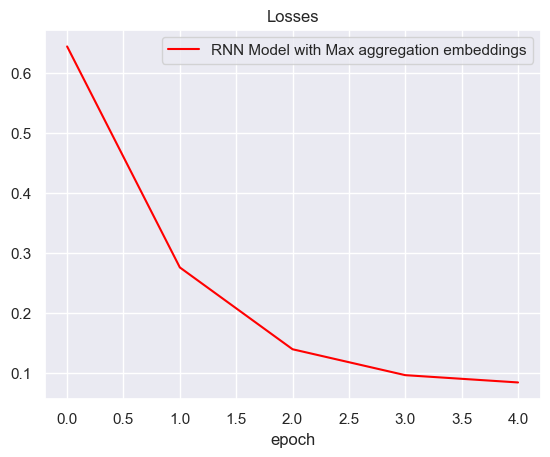

In [22]:
plt.plot(np.arange(len(rnn_losses_max_emb)), rnn_losses_max_emb, color='red', label='RNN Model with Max aggregation embeddings')

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Best accuracy for RNN Model with Max aggregation embeddings: 93.40


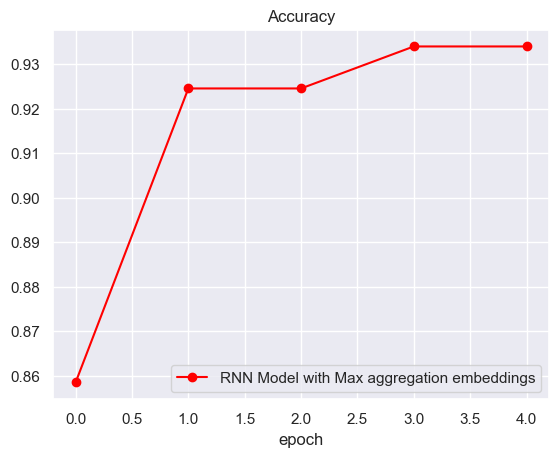

In [24]:

plt.plot(np.arange(len(rnn_accuracy_max_emb)), rnn_accuracy_max_emb, '-o', color='red', label='RNN Model with Max aggregation embeddings')
print(f"Best accuracy for RNN Model with Max aggregation embeddings: {(max(rnn_accuracy_max_emb)*100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [28]:
test_df = pd.read_csv('data/test_promo.csv', sep=';')
predict(rnn_model_max_emb, test_df.text.values)

,text,prediction
0,"Заправляйтесь топливом на АЗС ""Роснефть"" в период с 1 мая по 31 августа 2022 года и получите скидку 50 копеек с каждого литра топлива марки АИ-95 и АИ-92.",np
1,"При заправке от 40 литров на АЗС ""Лукойл"" в период акции, вы получите скидку 10% на все виды топлива.",stiu
2,"Покупайте акционный товар на АЗС ""Газпром"" и получите возможность участвовать в розыгрыше ценных призов.",stiu
3,"Заправьтесь на АЗС ""Башнефть"" и получите скидку на топливо в размере 20 копеек на каждый литр топлива марки АИ-95 при покупке кофе.",stiu
4,"На АЗС ""Сургутнефтегаз"" при заправке более 50 литров топлива, вы получаете скидку 25 копеек с каждого литра.",stiu
5,"При покупке топлива на АЗС ""Татнефть"" на сумму более 1 000 рублей, вы получаете купон на скидку 5% на следующую покупку.",stiu
6,"При единовременной заправке на АЗС ""Шелл"" от 60 литров, вы получаете возможность участвовать в лотерее с ценными призами.",stiu
7,"При заправке от 80 литров на АЗС ЕКА, вы получите скидочный купон на 100 рублей на следующую заправку.",stiu
8,На АЗС Нефтьмагистраль при каждой заправке свыше 100 литров топлива марки АИ-95 вы получаете карту лояльности с начисленными бонусами.,stiu
9,На АЗС Трасса при единовременной заправке свыше 200 литров предоставляется скидка в размере 0.50 руб./литр на все виды топлива.,stiu


#### Mean embeddings aggregation

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   10    |   0.630578   |     -      |     -     |   4.22   
   1    |   20    |   0.633109   |     -      |     -     |   2.44   
   1    |   30    |   0.539411   |     -      |     -     |   2.73   
   1    |   40    |   0.572482   |     -      |     -     |   2.12   
   1    |   50    |   0.500273   |     -      |     -     |   2.70   
   1    |   52    |   0.326732   |     -      |     -     |   0.55   
----------------------------------------------------------------------
   1    |    -    |   0.566841   |  0.418281  |   82.08   |   18.44  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   10    |   0.498070   |     -      |     -     |   2.9

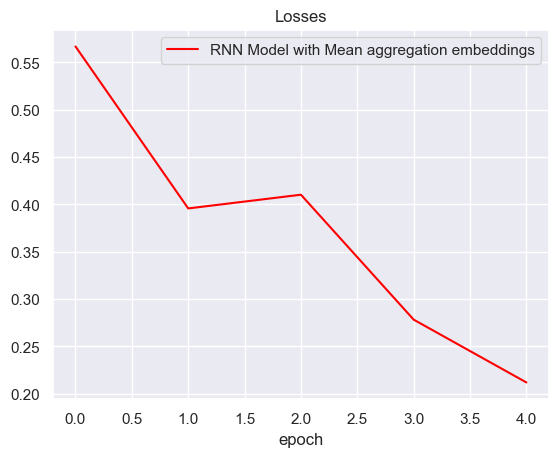

Best accuracy for RNN Model with Mean aggregation embeddings: 90.57


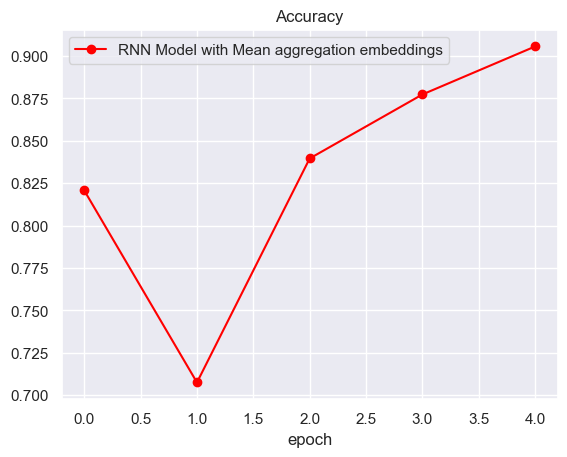

,text,prediction
0,"Заправляйтесь топливом на АЗС ""Роснефть"" в период с 1 мая по 31 августа 2022 года и получите скидку 50 копеек с каждого литра топлива марки АИ-95 и АИ-92.",np
1,"При заправке от 40 литров на АЗС ""Лукойл"" в период акции, вы получите скидку 10% на все виды топлива.",np
2,"Покупайте акционный товар на АЗС ""Газпром"" и получите возможность участвовать в розыгрыше ценных призов.",stiu
3,"Заправьтесь на АЗС ""Башнефть"" и получите скидку на топливо в размере 20 копеек на каждый литр топлива марки АИ-95 при покупке кофе.",np
4,"На АЗС ""Сургутнефтегаз"" при заправке более 50 литров топлива, вы получаете скидку 25 копеек с каждого литра.",np
5,"При покупке топлива на АЗС ""Татнефть"" на сумму более 1 000 рублей, вы получаете купон на скидку 5% на следующую покупку.",np
6,"При единовременной заправке на АЗС ""Шелл"" от 60 литров, вы получаете возможность участвовать в лотерее с ценными призами.",np
7,"При заправке от 80 литров на АЗС ЕКА, вы получите скидочный купон на 100 рублей на следующую заправку.",np
8,На АЗС Нефтьмагистраль при каждой заправке свыше 100 литров топлива марки АИ-95 вы получаете карту лояльности с начисленными бонусами.,np
9,На АЗС Трасса при единовременной заправке свыше 200 литров предоставляется скидка в размере 0.50 руб./литр на все виды топлива.,np


In [48]:
epochs = 5
rnn_model_mean_emb = RNNCharLM(256, len(vocab), aggregation_type='mean')
rnn_model_mean_emb.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(rnn_model_mean_emb.parameters())
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)
rnn_losses_mean_emb, rnn_accuracy_mean_emb = train(
    rnn_model_mean_emb,
    criterion,
    optimizer,
    scheduler,
    train_dataloader,
    eval_dataloader,
    epochs=epochs,
    evaluation=True
)
plt.plot(np.arange(len(rnn_losses_mean_emb)), rnn_losses_mean_emb, color='red',
         label='RNN Model with Mean aggregation embeddings')

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(np.arange(len(rnn_accuracy_mean_emb)), rnn_accuracy_mean_emb, '-o', color='red',
         label='RNN Model with Mean aggregation embeddings')
print(f"Best accuracy for RNN Model with Mean aggregation embeddings: {(max(rnn_accuracy_mean_emb) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()
predict(rnn_model_mean_emb, test_df.text.values)

### LSTM model

In [30]:
class LSTMCharLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int,aggregation_type: str = 'max'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, 2)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

#### Max embeddings aggregation

In [31]:
epochs = 5
lstm_model_max_emb = LSTMCharLM(256, len(vocab), aggregation_type='max')
lstm_model_max_emb.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(lstm_model_max_emb.parameters())
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, # Default value
                                            num_training_steps=total_steps)
lstm_losses_max_emb, lstm_accuracy_max_emb = train(
    lstm_model_max_emb,
    criterion,
    optimizer,
    scheduler,
    train_dataloader,
    eval_dataloader,
    epochs=epochs,
    evaluation=True
)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   10    |   0.644042   |     -      |     -     |   4.93   
   1    |   20    |   0.544450   |     -      |     -     |   3.44   
   1    |   30    |   0.369551   |     -      |     -     |   2.58   
   1    |   40    |   0.293327   |     -      |     -     |   3.11   
   1    |   50    |   0.272035   |     -      |     -     |   3.66   
   1    |   52    |   0.284821   |     -      |     -     |   0.55   
----------------------------------------------------------------------
   1    |    -    |   0.423542   |  0.265288  |   87.74   |   22.42  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   10    |   0.130809   |     -      |     -     |   5.3

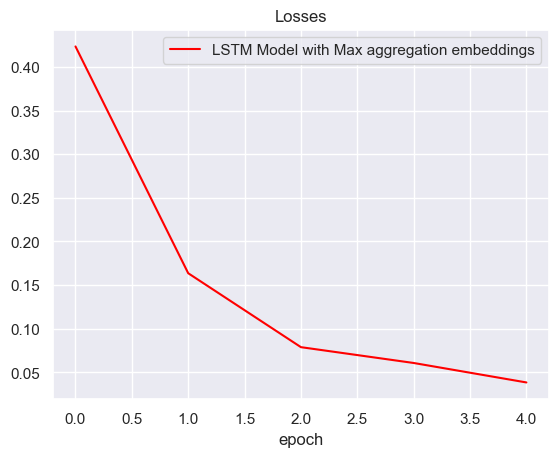

In [32]:
plt.plot(np.arange(len(lstm_losses_max_emb)), lstm_losses_max_emb, color='red', label='LSTM Model with Max aggregation embeddings')

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Best accuracy for LSTM Model with Max aggregation embeddings: 97.17


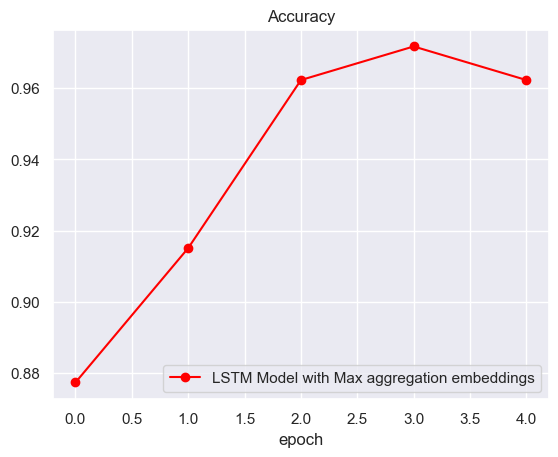

In [33]:

plt.plot(np.arange(len(lstm_accuracy_max_emb)),lstm_accuracy_max_emb, '-o', color='red', label='LSTM Model with Max aggregation embeddings')
print(f"Best accuracy for LSTM Model with Max aggregation embeddings: {(max(lstm_accuracy_max_emb)*100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [34]:
predict(lstm_model_max_emb, test_df.text.values)

,text,prediction
0,"Заправляйтесь топливом на АЗС ""Роснефть"" в период с 1 мая по 31 августа 2022 года и получите скидку 50 копеек с каждого литра топлива марки АИ-95 и АИ-92.",np
1,"При заправке от 40 литров на АЗС ""Лукойл"" в период акции, вы получите скидку 10% на все виды топлива.",np
2,"Покупайте акционный товар на АЗС ""Газпром"" и получите возможность участвовать в розыгрыше ценных призов.",stiu
3,"Заправьтесь на АЗС ""Башнефть"" и получите скидку на топливо в размере 20 копеек на каждый литр топлива марки АИ-95 при покупке кофе.",stiu
4,"На АЗС ""Сургутнефтегаз"" при заправке более 50 литров топлива, вы получаете скидку 25 копеек с каждого литра.",np
5,"При покупке топлива на АЗС ""Татнефть"" на сумму более 1 000 рублей, вы получаете купон на скидку 5% на следующую покупку.",stiu
6,"При единовременной заправке на АЗС ""Шелл"" от 60 литров, вы получаете возможность участвовать в лотерее с ценными призами.",stiu
7,"При заправке от 80 литров на АЗС ЕКА, вы получите скидочный купон на 100 рублей на следующую заправку.",stiu
8,На АЗС Нефтьмагистраль при каждой заправке свыше 100 литров топлива марки АИ-95 вы получаете карту лояльности с начисленными бонусами.,np
9,На АЗС Трасса при единовременной заправке свыше 200 литров предоставляется скидка в размере 0.50 руб./литр на все виды топлива.,np


#### Mean embeddings aggregation

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   10    |   0.687175   |     -      |     -     |   4.66   
   1    |   20    |   0.654267   |     -      |     -     |   2.76   
   1    |   30    |   0.509750   |     -      |     -     |   2.67   
   1    |   40    |   0.438008   |     -      |     -     |   2.97   
   1    |   50    |   0.459233   |     -      |     -     |   2.90   
   1    |   52    |   0.167384   |     -      |     -     |   0.37   
----------------------------------------------------------------------
   1    |    -    |   0.537854   |  0.360946  |   82.08   |   20.27  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   10    |   0.227577   |     -      |     -     |   3.0

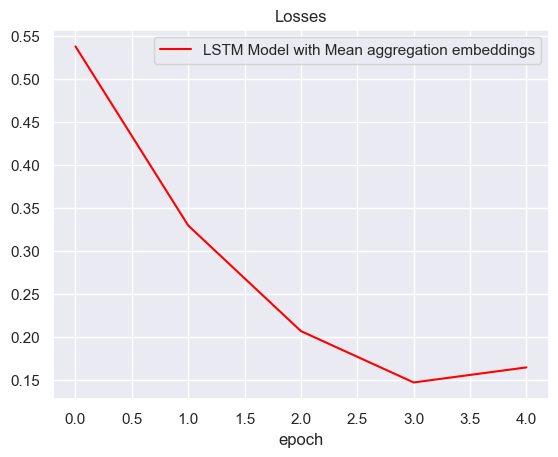

Best accuracy for LSTM Model with Mean aggregation embeddings: 96.23


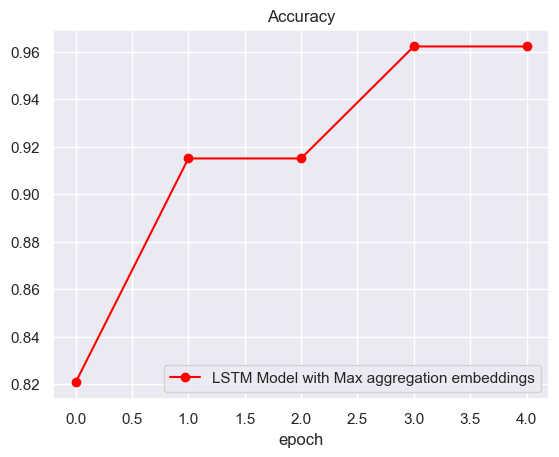

,text,prediction
0,"Заправляйтесь топливом на АЗС ""Роснефть"" в период с 1 мая по 31 августа 2022 года и получите скидку 50 копеек с каждого литра топлива марки АИ-95 и АИ-92.",np
1,"При заправке от 40 литров на АЗС ""Лукойл"" в период акции, вы получите скидку 10% на все виды топлива.",np
2,"Покупайте акционный товар на АЗС ""Газпром"" и получите возможность участвовать в розыгрыше ценных призов.",stiu
3,"Заправьтесь на АЗС ""Башнефть"" и получите скидку на топливо в размере 20 копеек на каждый литр топлива марки АИ-95 при покупке кофе.",np
4,"На АЗС ""Сургутнефтегаз"" при заправке более 50 литров топлива, вы получаете скидку 25 копеек с каждого литра.",np
5,"При покупке топлива на АЗС ""Татнефть"" на сумму более 1 000 рублей, вы получаете купон на скидку 5% на следующую покупку.",stiu
6,"При единовременной заправке на АЗС ""Шелл"" от 60 литров, вы получаете возможность участвовать в лотерее с ценными призами.",np
7,"При заправке от 80 литров на АЗС ЕКА, вы получите скидочный купон на 100 рублей на следующую заправку.",np
8,На АЗС Нефтьмагистраль при каждой заправке свыше 100 литров топлива марки АИ-95 вы получаете карту лояльности с начисленными бонусами.,np
9,На АЗС Трасса при единовременной заправке свыше 200 литров предоставляется скидка в размере 0.50 руб./литр на все виды топлива.,np


In [47]:
epochs = 5
lstm_model_mean_emb = LSTMCharLM(256, len(vocab), aggregation_type='mean')
lstm_model_mean_emb.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(lstm_model_mean_emb.parameters())
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)
lstm_losses_mean_emb, lstm_accuracy_mean_emb = train(
    lstm_model_mean_emb,
    criterion,
    optimizer,
    scheduler,
    train_dataloader,
    eval_dataloader,
    epochs=epochs,
    evaluation=True
)
plt.plot(np.arange(len(lstm_losses_mean_emb)), lstm_losses_mean_emb, color='red',
         label='LSTM Model with Mean aggregation embeddings')

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(np.arange(len(lstm_accuracy_mean_emb)), lstm_accuracy_mean_emb, '-o', color='red',
         label='LSTM Model with Max aggregation embeddings')
print(f"Best accuracy for LSTM Model with Mean aggregation embeddings: {(max(lstm_accuracy_mean_emb) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()
predict(lstm_model_mean_emb, test_df.text.values)

### GRU model

In [35]:
class GRUCharLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int,aggregation_type: str = 'max'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, 2)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

#### Max embeddings aggregation

In [36]:
epochs = 5
gru_model_max_emb = GRUCharLM(256, len(vocab), aggregation_type='max')
gru_model_max_emb.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(gru_model_max_emb.parameters())
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, # Default value
                                            num_training_steps=total_steps)
gru_losses_max_emb, gru_accuracy_max_emb = train(
    gru_model_max_emb,
    criterion,
    optimizer,
    scheduler,
    train_dataloader,
    eval_dataloader,
    epochs=epochs,
    evaluation=True
)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   10    |   0.630582   |     -      |     -     |   4.88   
   1    |   20    |   0.468559   |     -      |     -     |   3.86   
   1    |   30    |   0.373249   |     -      |     -     |   3.98   
   1    |   40    |   0.310215   |     -      |     -     |   2.49   
   1    |   50    |   0.240745   |     -      |     -     |   2.31   
   1    |   52    |   0.217705   |     -      |     -     |   0.50   
----------------------------------------------------------------------
   1    |    -    |   0.401877   |  0.279931  |   87.74   |   22.59  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   10    |   0.162644   |     -      |     -     |   3.4

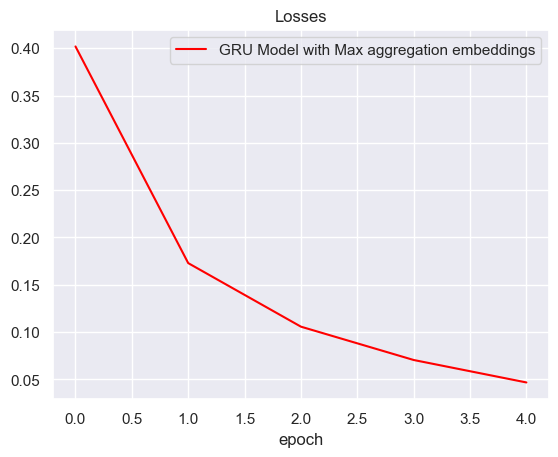

In [40]:
plt.plot(np.arange(len(gru_losses_max_emb)), gru_losses_max_emb, color='red', label='GRU Model with Max aggregation embeddings')

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Best accuracy for GRU Model with Max aggregation embeddings: 95.28


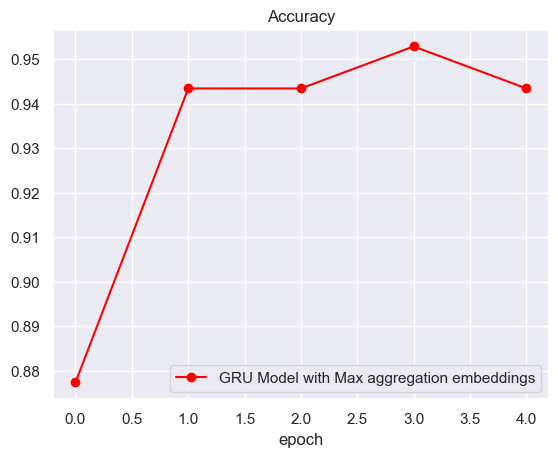

In [41]:

plt.plot(np.arange(len(gru_accuracy_max_emb)), gru_accuracy_max_emb, '-o', color='red', label='GRU Model with Max aggregation embeddings')
print(f"Best accuracy for GRU Model with Max aggregation embeddings: {(max(gru_accuracy_max_emb)*100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [42]:
predict(gru_model_max_emb, test_df.text.values)

,text,prediction
0,"Заправляйтесь топливом на АЗС ""Роснефть"" в период с 1 мая по 31 августа 2022 года и получите скидку 50 копеек с каждого литра топлива марки АИ-95 и АИ-92.",np
1,"При заправке от 40 литров на АЗС ""Лукойл"" в период акции, вы получите скидку 10% на все виды топлива.",np
2,"Покупайте акционный товар на АЗС ""Газпром"" и получите возможность участвовать в розыгрыше ценных призов.",stiu
3,"Заправьтесь на АЗС ""Башнефть"" и получите скидку на топливо в размере 20 копеек на каждый литр топлива марки АИ-95 при покупке кофе.",stiu
4,"На АЗС ""Сургутнефтегаз"" при заправке более 50 литров топлива, вы получаете скидку 25 копеек с каждого литра.",np
5,"При покупке топлива на АЗС ""Татнефть"" на сумму более 1 000 рублей, вы получаете купон на скидку 5% на следующую покупку.",stiu
6,"При единовременной заправке на АЗС ""Шелл"" от 60 литров, вы получаете возможность участвовать в лотерее с ценными призами.",np
7,"При заправке от 80 литров на АЗС ЕКА, вы получите скидочный купон на 100 рублей на следующую заправку.",stiu
8,На АЗС Нефтьмагистраль при каждой заправке свыше 100 литров топлива марки АИ-95 вы получаете карту лояльности с начисленными бонусами.,np
9,На АЗС Трасса при единовременной заправке свыше 200 литров предоставляется скидка в размере 0.50 руб./литр на все виды топлива.,np


#### Mean embeddings aggregation

In [53]:
epochs = 5
gru_model_mean_emb = GRUCharLM(256, len(vocab), aggregation_type='mean')
gru_model_mean_emb.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(gru_model_mean_emb.parameters())
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, # Default value
                                            num_training_steps=total_steps)
gru_losses_mean_emb, gru_accuracy_mean_emb = train(
    gru_model_mean_emb,
    criterion,
    optimizer,
    scheduler,
    train_dataloader,
    eval_dataloader,
    epochs=epochs,
    evaluation=True
)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   10    |   0.683692   |     -      |     -     |   5.84   
   1    |   20    |   0.617958   |     -      |     -     |   4.19   
   1    |   30    |   0.521908   |     -      |     -     |   3.71   
   1    |   40    |   0.560192   |     -      |     -     |   4.26   
   1    |   50    |   0.547104   |     -      |     -     |   2.71   
   1    |   52    |   0.480767   |     -      |     -     |   0.50   
----------------------------------------------------------------------
   1    |    -    |   0.584033   |  0.411003  |   80.19   |   26.40  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   10    |   0.381932   |     -      |     -     |   5.0

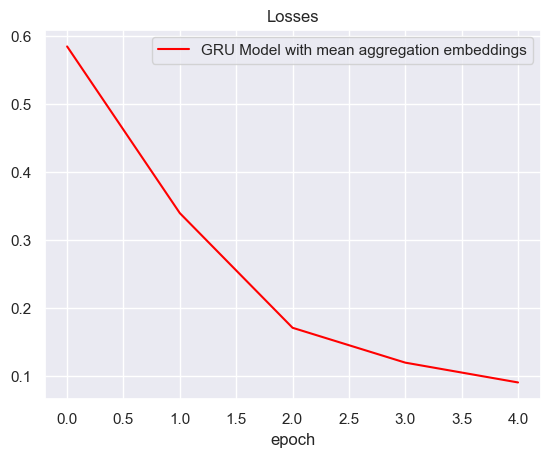

In [54]:
plt.plot(np.arange(len(gru_losses_mean_emb)), gru_losses_mean_emb, color='red', label='GRU Model with mean aggregation embeddings')

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Best accuracy for GRU Model with mean aggregation embeddings: 95.28


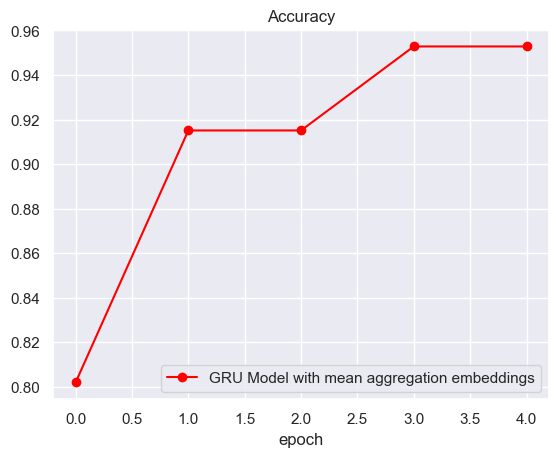

In [55]:

plt.plot(np.arange(len(gru_accuracy_mean_emb)), gru_accuracy_mean_emb, '-o', color='red', label='GRU Model with mean aggregation embeddings')
print(f"Best accuracy for GRU Model with mean aggregation embeddings: {(max(gru_accuracy_mean_emb)*100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [56]:
predict(gru_model_mean_emb, test_df.text.values)

,text,prediction
0,"Заправляйтесь топливом на АЗС ""Роснефть"" в период с 1 мая по 31 августа 2022 года и получите скидку 50 копеек с каждого литра топлива марки АИ-95 и АИ-92.",np
1,"При заправке от 40 литров на АЗС ""Лукойл"" в период акции, вы получите скидку 10% на все виды топлива.",np
2,"Покупайте акционный товар на АЗС ""Газпром"" и получите возможность участвовать в розыгрыше ценных призов.",stiu
3,"Заправьтесь на АЗС ""Башнефть"" и получите скидку на топливо в размере 20 копеек на каждый литр топлива марки АИ-95 при покупке кофе.",np
4,"На АЗС ""Сургутнефтегаз"" при заправке более 50 литров топлива, вы получаете скидку 25 копеек с каждого литра.",np
5,"При покупке топлива на АЗС ""Татнефть"" на сумму более 1 000 рублей, вы получаете купон на скидку 5% на следующую покупку.",stiu
6,"При единовременной заправке на АЗС ""Шелл"" от 60 литров, вы получаете возможность участвовать в лотерее с ценными призами.",np
7,"При заправке от 80 литров на АЗС ЕКА, вы получите скидочный купон на 100 рублей на следующую заправку.",np
8,На АЗС Нефтьмагистраль при каждой заправке свыше 100 литров топлива марки АИ-95 вы получаете карту лояльности с начисленными бонусами.,np
9,На АЗС Трасса при единовременной заправке свыше 200 литров предоставляется скидка в размере 0.50 руб./литр на все виды топлива.,np


In [57]:
rnn_model_max_emb.to('cpu')
lstm_model_max_emb.to('cpu')
rnn_model_mean_emb.to('cpu')
lstm_model_mean_emb.to('cpu')
gru_model_max_emb.to('cpu')
gru_model_mean_emb.to('cpu')

GRUCharLM(
  (embedding): Embedding(1109, 256)
  (rnn): GRU(256, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=2, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

## Обучение и тестирование BERT-based модели

Неплохие результаты обучения RNN-модели интересно сравнить с одной из лучших моделей, работающих с текстом, BERT.
Для этого необходимо подготовить специальный препроцессинг для получения правильных токенов для обучения. И далее дообучить модель на наших данных

In [58]:
# Specify `MAX_LEN`
MAX_LEN = 128
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,                   # Pad sentence to max length
            truncation=True,
            # return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [66]:
train_inputs, train_masks = preprocessing_for_bert(X_train.text.values)
eval_inputs, eval_masks = preprocessing_for_bert(X_test.text.values)
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train.values)
eval_labels = torch.tensor(y_test.values)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
eval_data = TensorDataset(eval_inputs, eval_masks, eval_labels)
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=batch_size)

E:\projects\innopolis_ai\venv\Lib\site-packages\transformers\tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [67]:

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [68]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=3):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler


def bert_predict(model, predict_data: List[str]):
    """
    Predict label
    """

    input_data = [t.to(device) for t in preprocessing_for_bert(predict_data)]

    with torch.no_grad():
        logits = model(*input_data)

    ids = logits.argmax(dim=1)
    predictions = [id2label[i] for i in ids.tolist()]
    result = pd.DataFrame(zip(predict_data, predictions), columns=['text', 'prediction'])
    return result

In [71]:
epochs = 5
loss_fn = nn.CrossEntropyLoss()
bert_classifier, optimizer, scheduler = initialize_model(epochs=5)
bert_losses, bert_accuracy = train(
    bert_classifier,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    eval_dataloader,
    epochs=epochs,
    evaluation=True
)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
E:\projects\innopolis_ai\venv\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementa

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   10    |   0.611943   |     -      |     -     |   12.63  
   1    |   20    |   0.468008   |     -      |     -     |   11.64  
   1    |   26    |   0.538667   |     -      |     -     |   6.03   
----------------------------------------------------------------------
   1    |    -    |   0.542350   |  0.489955  |   71.70   |   32.75  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   10    |   0.404982   |     -      |     -     |   12.54  
   2    |   20    |   0.209039   |     -      |     -     |   11.28  
   2    |   26    |   0.399681   |     -      |     -     |   5.79   
-----------------------------------------------------------------

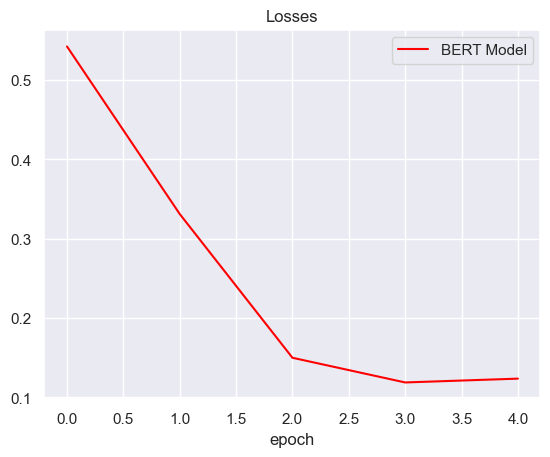

Best accuracy for BERT Model: 96.23


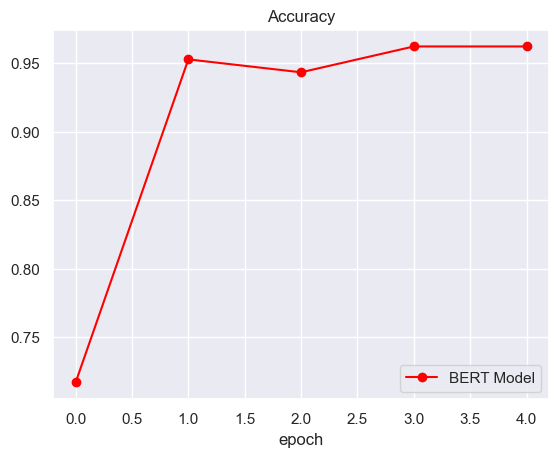

In [72]:
plt.plot(np.arange(len(bert_losses)), bert_losses, color='red',
         label='BERT Model')

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(np.arange(len(bert_accuracy)), bert_accuracy, '-o', color='red',
         label='BERT Model')
print(f"Best accuracy for BERT Model: {(max(bert_accuracy) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()


In [75]:
bert_predict(bert_classifier, test_df.text.values)

E:\projects\innopolis_ai\venv\Lib\site-packages\transformers\tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


,text,prediction
0,"Заправляйтесь топливом на АЗС ""Роснефть"" в период с 1 мая по 31 августа 2022 года и получите скидку 50 копеек с каждого литра топлива марки АИ-95 и АИ-92.",np
1,"При заправке от 40 литров на АЗС ""Лукойл"" в период акции, вы получите скидку 10% на все виды топлива.",np
2,"Покупайте акционный товар на АЗС ""Газпром"" и получите возможность участвовать в розыгрыше ценных призов.",stiu
3,"Заправьтесь на АЗС ""Башнефть"" и получите скидку на топливо в размере 20 копеек на каждый литр топлива марки АИ-95 при покупке кофе.",np
4,"На АЗС ""Сургутнефтегаз"" при заправке более 50 литров топлива, вы получаете скидку 25 копеек с каждого литра.",np
5,"При покупке топлива на АЗС ""Татнефть"" на сумму более 1 000 рублей, вы получаете купон на скидку 5% на следующую покупку.",stiu
6,"При единовременной заправке на АЗС ""Шелл"" от 60 литров, вы получаете возможность участвовать в лотерее с ценными призами.",stiu
7,"При заправке от 80 литров на АЗС ЕКА, вы получите скидочный купон на 100 рублей на следующую заправку.",np
8,На АЗС Нефтьмагистраль при каждой заправке свыше 100 литров топлива марки АИ-95 вы получаете карту лояльности с начисленными бонусами.,np
9,На АЗС Трасса при единовременной заправке свыше 200 литров предоставляется скидка в размере 0.50 руб./литр на все виды топлива.,np
